In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='collected_data.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('collected_data.zip')
f.keys()
!unzip collected_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: collected_data/0/0_390.jpg  
  inflating: collected_data/0/0_391.jpg  
  inflating: collected_data/0/0_392.jpg  
  inflating: collected_data/0/0_393.jpg  
  inflating: collected_data/0/0_394.jpg  
  inflating: collected_data/0/0_395.jpg  
  inflating: collected_data/0/0_396.jpg  
  inflating: collected_data/0/0_397.jpg  
  inflating: collected_data/0/0_398.jpg  
  inflating: collected_data/0/0_399.jpg  
  inflating: collected_data/0/0_4.jpg  
  inflating: collected_data/0/0_40.jpg  
  inflating: collected_data/0/0_400.jpg  
  inflating: collected_data/0/0_401.jpg  
  inflating: collected_data/0/0_402.jpg  
  inflating: collected_data/0/0_403.jpg  
  inflating: collected_data/0/0_404.jpg  
  inflating: collected_data/0/0_405.jpg  
  inflating: collected_data/0/0_406.jpg  
  inflating: collected_data/0/0_407.jpg  
  inflating: collected_data/0/0_408.jpg  
  inflating: collected_data/0/0_409.jpg  
  inflating: collected_data/

In [2]:
gpus = tf.config.list_logical_devices('GPU')
stg=tf.distribute.MirroredStrategy(gpus)

In [3]:
import cv2
import os
from tqdm import tqdm

folder_dir_tr = '/content/collected_data'


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [5]:
import tensorflow as tf

# Define the directory and batch size
folder_dir_tr = '/content/collected_data'  # Assuming this is your directory
batch_size = 16  # Example batch size
SIZE = (500,300)
# Define the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator with modified parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Apply the data generators to the dataset
"""train_set= train_datagen.flow_from_directory(
    '/content/collected_data/train',  # path to the training data directory
    target_size=(500, 300),
    batch_size=16,
    class_mode='categorical'
)

validation_set = test_datagen.flow_from_directory(
    '/content/collected_data/validation',  # path to the validation data directory
    target_size=(500, 300),
    batch_size=16,
    class_mode='categorical'
)
"""
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir_tr,
    shuffle=True,
    image_size=SIZE,  # Resize images to 244x244
    batch_size=batch_size,
    label_mode='categorical',
    seed=22,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset='training',  # Specify that this is the training set
    interpolation='bilinear'  # Interpolation method for resizing
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir_tr,
    shuffle=True,
    image_size=SIZE,  # Resize images to 244x244
    batch_size=batch_size,
    label_mode='categorical',
    seed=22,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset='validation',  # Specify that this is the validation set
    interpolation='bilinear'  # Interpolation method for resizing
)

# Optionally, you can print the class names and dataset sizes
class_names = train_set.class_names
print("Class names:", class_names)
print("Number of batches in training set:", len(train_set))
print("Number of batches in validation set:", len(validation_set))


Found 5314 files belonging to 10 classes.
Using 4252 files for training.
Found 5314 files belonging to 10 classes.
Using 1062 files for validation.
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Number of batches in training set: 266
Number of batches in validation set: 67


Found 5314 files belonging to 10 classes.


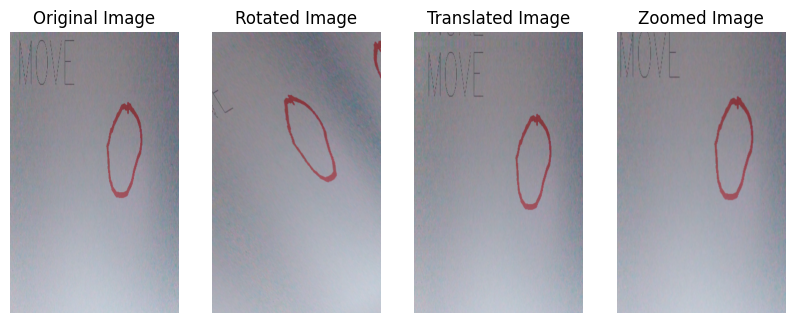

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've defined your image augmentation
rotation_augmentation = Sequential([preprocessing.RandomRotation(factor=0.2)], name="rotation_augmentation")
translation_augmentation = Sequential([preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)], name="translation_augmentation")
zoom_augmentation = Sequential([preprocessing.RandomZoom(height_factor=0.2)], name="zoom_augmentation")

# Load some sample images from your dataset
# Update the directory accordingly
folder_dir = '/content/collected_data'
sample_dataset = image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=SIZE,
    batch_size=1,
    label_mode='categorical',
    seed=22
)

# Apply each augmentation and display the results
for images, labels in sample_dataset.take(1):
    original_image = images[0].numpy()

    # Display the original image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(original_image.astype("uint8"))
    plt.title("Original Image")
    plt.axis("off")

    # Display the rotated image
    rotated_image = rotation_augmentation(images)[0].numpy()
    plt.subplot(1, 4, 2)
    plt.imshow(rotated_image.astype("uint8"))
    plt.title("Rotated Image")
    plt.axis("off")

    # Display the translated image
    translated_image = translation_augmentation(images)[0].numpy()
    plt.subplot(1, 4, 3)
    plt.imshow(translated_image.astype("uint8"))
    plt.title("Translated Image")
    plt.axis("off")

    # Display the zoomed image
    zoomed_image = zoom_augmentation(images)[0].numpy()
    plt.subplot(1, 4, 4)
    plt.imshow(zoomed_image.astype("uint8"))
    plt.title("Zoomed Image")
    plt.axis("off")

    plt.show()


In [1]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomTranslation, RandomFlip, RandomZoom
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception, DenseNet121, MobileNetV2, InceptionV3

no_of_classes = 10
SIZE = SIZE
with stg.scope():
    img_augmentation = Sequential(
    [
        RandomRotation(factor=0.01),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.2)
    ],
    name="img_augmentation"
    )

    base_model = InceptionV3(weights="imagenet", input_shape=(500,300, 3), include_top=False)
    inputs = Input(shape=(500, 300, 3))
    x = img_augmentation(inputs)
    outputs = base_model(x)

    x = GlobalAveragePooling2D()(outputs)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(no_of_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.1),
        metrics=['accuracy'])

model.summary()

NameError: name 'SIZE' is not defined

In [17]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=1,
                                 verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=10,
                                verbose=1)

callbacks = [lr_scheduler, early_stopping]


In [18]:
import tensorflow as tf

model.trainable = False

history = model.fit(train_set, epochs=10, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))


Epoch 1/3
266/266 [==============================] - 160s 444ms/step - loss: 2.3301 - accuracy: 0.1065 - val_loss: 26.9092 - val_accuracy: 0.0951 - lr: 0.0010
Epoch 2/3
266/266 [==============================] - 116s 431ms/step - loss: 2.3073 - accuracy: 0.0934 - val_loss: 2.3059 - val_accuracy: 0.1008 - lr: 0.0010
Epoch 3/3
266/266 [==============================] - ETA: 0s - loss: 2.3122 - accuracy: 0.0974
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
266/266 [==============================] - 117s 434ms/step - loss: 2.3122 - accuracy: 0.0974 - val_loss: 2.4668 - val_accuracy: 0.1017 - lr: 0.0010


In [19]:
test_loss, test_acc = model.evaluate_generator(validation_set)
print('Val accuracy:', test_acc)


<ipython-input-19-cf161702a674>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(validation_set)


Val accuracy: 0.10169491171836853


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, roc_curve, auc, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

# Assuming you have your test_set defined
# Replace it with your actual test dataset
test_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir_tr,
    shuffle=False,
    image_size=SIZE,
    batch_size=batch_size,
    label_mode='categorical'
)

# Evaluate the model on the test set
y_true = np.concatenate([y for x, y in test_set], axis=0)
y_pred_prob = model.predict(test_set)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)
import seaborn as sns

class_names = [str(i) for i in range(10)]
# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print("Classification Report:")
print(class_report)

# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC-AUC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'Macro-average ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

# F1 Score, Recall, Precision
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")


Found 5314 files belonging to 10 classes.
